In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#!pip install keras-preprocessing==1.0.5

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
directory_path = "D:/x_ray_images_unzip"
all_xray_df = pd.read_csv("D:/x_ray_images_unzip/Data_Entry_2017.csv")
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(directory_path, 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
34173,00008951_006.png,No Finding,6,8951,56,M,PA,2500,2048,0.168,0.168,NaN,D:/x_ray_images_unzip\images_004\images\000089...
43540,00011237_004.png,No Finding,4,11237,55,F,PA,2978,2991,0.143,0.143,NaN,D:/x_ray_images_unzip\images_005\images\000112...
68580,00016934_031.png,No Finding,31,16934,56,M,AP,2500,2048,0.168,0.168,NaN,D:/x_ray_images_unzip\images_008\images\000169...


In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

In [4]:
print(label_counts)

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Atelectasis|Effusion         1165
Pleural_Thickening           1126
Cardiomegaly                 1093
Emphysema                     892
Infiltration|Nodule           829
Name: Finding Labels, dtype: int64


In [5]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
42429,00010914_005.png,Nodule,5,10914,49,M,PA,2794,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8723,00002300_031.png,Effusion,31,2300,81,F,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90934,00022658_000.png,Infiltration,0,22658,53,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [8]:
sample_weights[:15]

array([1.04, 2.04, 2.04, 0.04, 1.04, 1.04, 1.04, 2.04, 1.04, 1.04, 1.04,
       1.04, 2.04, 0.04, 0.04])

In [9]:
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2

sample_weights /= sample_weights.sum()

all_xray_df = all_xray_df.sample(40000, weights=sample_weights)



In [10]:
sample_weights[:15]

array([1.21409093e-05, 2.38148605e-05, 2.38148605e-05, 4.66958048e-07,
       1.21409093e-05, 1.21409093e-05, 1.21409093e-05, 2.38148605e-05,
       1.21409093e-05, 1.21409093e-05, 1.21409093e-05, 1.21409093e-05,
       2.38148605e-05, 4.66958048e-07, 4.66958048e-07])

In [12]:
all_xray_df.head()
print(len(all_xray_df))

40000


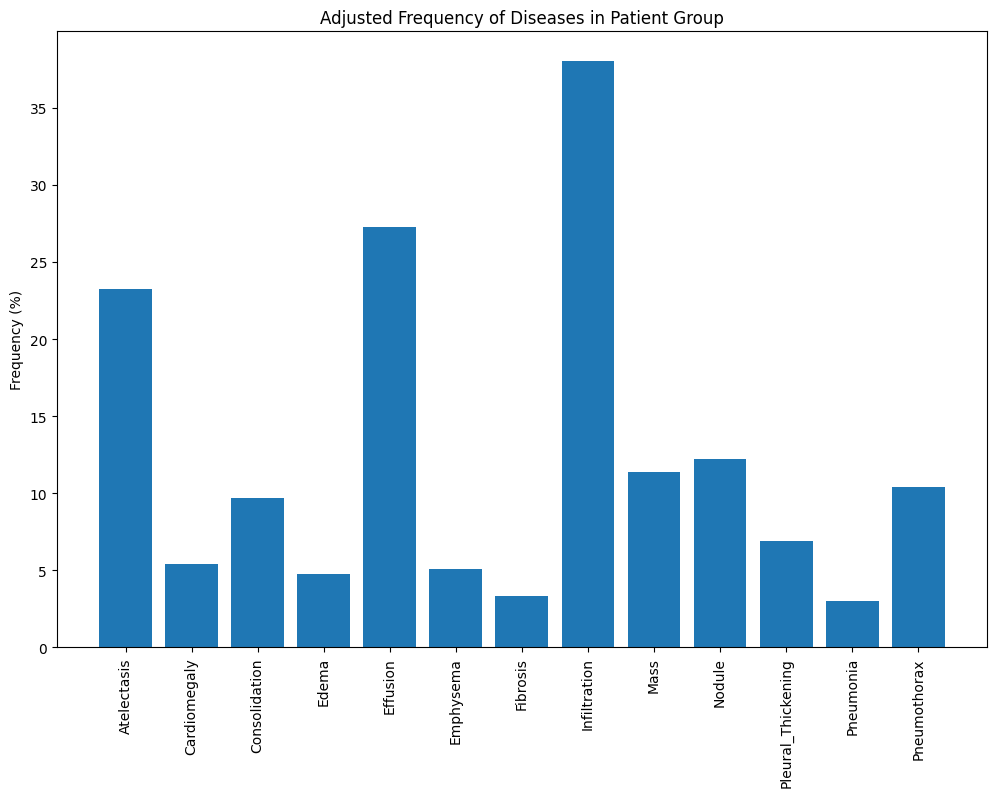

In [13]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# preparing training data

In [14]:
print(all_labels)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [16]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
29188,00007612_000.png,Infiltration,0,7612,65,F,PA,2366,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43500,00011226_020.png,Atelectasis|Consolidation|Pleural_Thickening,20,11226,45,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95901,00025238_010.png,Infiltration,10,25238,29,F,AP,2892,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
100419,00026622_000.png,Atelectasis|Effusion|Infiltration,0,26622,44,F,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15920,00004209_000.png,Infiltration|Nodule,0,4209,54,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,00000963_012.png,Atelectasis,12,963,40,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15122,00003973_013.png,Cardiomegaly|Fibrosis,13,3973,45,F,PA,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61059,00015064_000.png,Effusion|Nodule,0,15064,75,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25850,00006794_002.png,Nodule,2,6794,67,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
all_xray_df.columns


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'disease_vec'],
      dtype='object')

In [19]:
all_xray_df['path'][:15]

29188     D:/x_ray_images_unzip\images_004\images\000076...
43500     D:/x_ray_images_unzip\images_005\images\000112...
95901     D:/x_ray_images_unzip\images_011\images\000252...
100419    D:/x_ray_images_unzip\images_011\images\000266...
15920     D:/x_ray_images_unzip\images_003\images\000042...
53052     D:/x_ray_images_unzip\images_006\images\000133...
27936     D:/x_ray_images_unzip\images_004\images\000072...
101352    D:/x_ray_images_unzip\images_011\images\000269...
56255     D:/x_ray_images_unzip\images_007\images\000140...
57833     D:/x_ray_images_unzip\images_007\images\000143...
61120     D:/x_ray_images_unzip\images_007\images\000150...
90645     D:/x_ray_images_unzip\images_010\images\000225...
87472     D:/x_ray_images_unzip\images_010\images\000216...
46652     D:/x_ray_images_unzip\images_006\images\000119...
52651     D:/x_ray_images_unzip\images_006\images\000132...
Name: path, dtype: object

In [24]:
from sklearn.model_selection import train_test_split

# Split into train and temporary set (70% train + 30% temp)
train_df, temp_df = train_test_split(all_xray_df,
                                     test_size=0.3,
                                     random_state=2018,
                                     stratify=all_xray_df['Finding Labels'].map(lambda x: x[:4]))

# Further split temp set into validation and test (20% validation + 10% test)
valid_df, test_df = train_test_split(temp_df,
                                     test_size=1/3,
                                     random_state=2018,
                                     stratify=temp_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])


train 28000 validation 8000 test 4000


In [25]:
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define a custom data generator with CLAHE
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, clahe_clip_limit=3.0, **kwargs):
        super().__init__(**kwargs)
        self.clahe_clip_limit = clahe_clip_limit

    def clahe_augment(self, image):
        clahe = cv2.createCLAHE(clipLimit=self.clahe_clip_limit)
        return clahe.apply(image)

    def random_transform(self, x, seed=None):
        x = self.clahe_augment(x)
        return super().random_transform(x, seed)

In [26]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
train_datagen = CustomImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [27]:
val_datagen = CustomImageDataGenerator()

In [28]:
test_datagen = CustomImageDataGenerator()

In [29]:
def split_labels(labels):
    list1 = []
    for i in labels['Finding Labels'].split('|'):
        if i != "":
            list1.append(i)
    return list1

In [30]:
valid_df['newLabel'] = valid_df.apply(split_labels, axis=1)
train_df['newLabel'] = train_df.apply(split_labels, axis=1)
test_df['newLabel'] = test_df.apply(split_labels, axis=1)

In [31]:
train_generator = train_datagen.flow_from_dataframe(
dataframe=train_df,
directory= None,
x_col="path",
y_col="newLabel",
#subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode='categorical',
color_mode ='rgb',
target_size=(256,256))

Found 28000 validated image filenames belonging to 14 classes.


In [32]:
val_generator = val_datagen.flow_from_dataframe(
dataframe=valid_df,
directory= None,
x_col="path",
y_col="newLabel",
#subset="training",
batch_size=32,
seed=42,
shuffle=False,
class_mode='categorical',
color_mode ='rgb',
target_size=(256,256))

Found 8000 validated image filenames belonging to 14 classes.


In [33]:
test_generator = val_datagen.flow_from_dataframe(
dataframe=test_df,
directory= None,
x_col="path",
y_col="newLabel",
#subset="training",
batch_size=32,
seed=42,
shuffle=False,
class_mode='categorical',
color_mode ='rgb',
target_size=(256,256))

Found 4000 validated image filenames belonging to 14 classes.


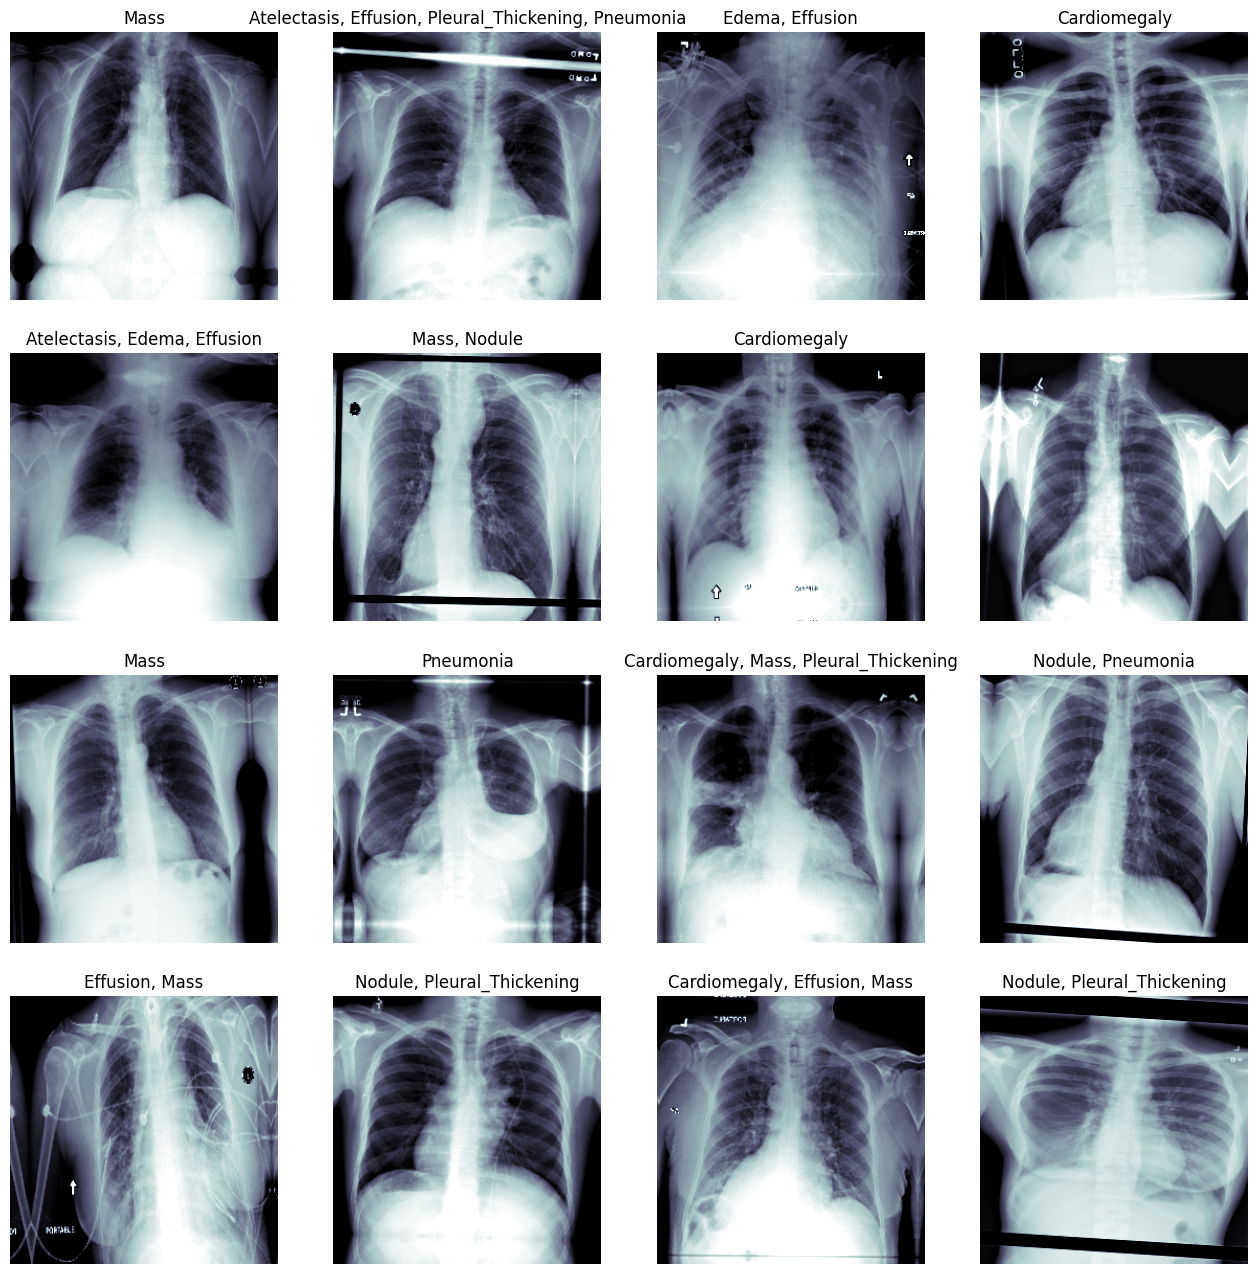

In [34]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# LETS TRAIN VISUAL TRANSFORMER

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, Permute
resize_rescale_hf = tf.keras.Sequential ( [
    Resizing (224, 224),
    Rescaling (1./255),
    Permute ((3,1,2))
])

In [44]:
from tensorflow.keras.layers import Input,Flatten,BatchNormalization, Dropout
from tensorflow.keras.layers import Dense
from transformers import AutoImageProcessor, TFViTModel

vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model.trainable = False
inputs = Input(shape = (256,256,3))
x= resize_rescale_hf(inputs)
x = vit_model.vit(x)[0]#[:,0,:]
x = tf.keras.layers.MaxPooling1D()(x)[:,0,:]
x = Flatten()(x)
x = Dense(512,activation = 'relu')(x)
output = Dense(14,activation='sigmoid')(x)  #ATTACH NEW CLASSIFICATION HEAD
hf_model = tf.keras.Model(inputs = inputs,outputs = output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [45]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 768)          0     

In [46]:
hf_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="/kaggle/working/best_weights_vit.h5",  # Replace with the desired save path
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [48]:
early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=2,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

In [49]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [50]:
history = hf_model.fit(
train_generator,
steps_per_epoch=STEP_SIZE_TRAIN,
validation_steps=STEP_SIZE_VALID,
validation_data = val_generator,
epochs = 10,
verbose = 1,
callbacks = [checkpoint_callback,early_stopping_callback]
)

Epoch 1/10
875/875 [==============================] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8839 - mae: 0.1824
Epoch 1: val_binary_accuracy improved from -inf to 0.88448, saving model to /kaggle/working/best_weights_vit.h5
875/875 [==============================] - 1739s 2s/step - loss: 0.3108 - binary_accuracy: 0.8839 - mae: 0.1824 - val_loss: 0.4726 - val_binary_accuracy: 0.8845 - val_mae: 0.3617
Epoch 2/10
875/875 [==============================] - ETA: 0s - loss: 0.3071 - binary_accuracy: 0.8849 - mae: 0.1806
Epoch 2: val_binary_accuracy did not improve from 0.88448
875/875 [==============================] - 1544s 2s/step - loss: 0.3071 - binary_accuracy: 0.8849 - mae: 0.1806 - val_loss: 0.4530 - val_binary_accuracy: 0.8844 - val_mae: 0.3418
Epoch 3/10
875/875 [==============================] - ETA: 0s - loss: 0.3062 - binary_accuracy: 0.8849 - mae: 0.1804
Epoch 3: val_binary_accuracy did not improve from 0.88448
Restoring model weights from the end of the best epoch: 1.
875/

In [51]:
hf_model.save('/kaggle/working/vit_model.h5')

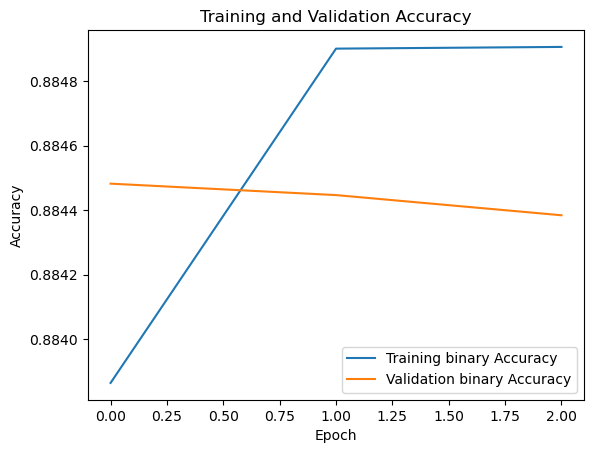

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='Training binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [53]:
hf_model.evaluate(test_generator)

125/125 [==============================] - 134s 1s/step - loss: 0.4727 - binary_accuracy: 0.8846 - mae: 0.3618


[0.47266149520874023, 0.884589433670044, 0.36177706718444824]

# LETS TRAIN RESNET152

In [54]:
from tensorflow.keras.layers import Resizing, Rescaling, Permute
resize_rescale_hf_without_transpose = tf.keras.Sequential ( [
    Resizing (224, 224),
    Rescaling (1./255),
])

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model

# Load the pretrained ResNet152 model
pretrained_model = ResNet152(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Freeze layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add layers for classification on top of ResNet152
inputs = Input(shape = (256,256,3))
x= resize_rescale_hf_without_transpose(inputs)
x = pretrained_model(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

# Create the final model
resnet152_model = Model(inputs=inputs, outputs=predictions)

234698864/234698864 [==============================] - 2s 0us/step


In [11]:
#resnet152_model.load_weights("/kaggle/input/saved-models-all/all_models/best_weights_resnet.h5")

In [56]:
#resnet152_model.save("/kaggle/working/resnet_model.h5")

In [57]:
resnet152_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="/kaggle/working/best_weights_resnet.h5",  # Replace with the desired save path
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [59]:
early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=2,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

In [60]:
history = resnet152_model.fit(
train_generator,
#batch_size = 32,
steps_per_epoch=STEP_SIZE_TRAIN,
validation_steps=STEP_SIZE_VALID,
validation_data = val_generator,
epochs = 10,
verbose = 1,
callbacks = [checkpoint_callback,early_stopping_callback]
#class_weight = class_weights,
#callbacks = [checkpoint_callback]
)

Epoch 1/10
875/875 [==============================] - ETA: 0s - loss: 0.3978 - binary_accuracy: 0.8696 - mae: 0.1826
Epoch 1: val_binary_accuracy improved from -inf to 0.88446, saving model to /kaggle/working/best_weights_resnet.h5
875/875 [==============================] - 1484s 2s/step - loss: 0.3978 - binary_accuracy: 0.8696 - mae: 0.1826 - val_loss: 0.3275 - val_binary_accuracy: 0.8845 - val_mae: 0.1655
Epoch 2/10
875/875 [==============================] - ETA: 0s - loss: 0.3164 - binary_accuracy: 0.8833 - mae: 0.1828
Epoch 2: val_binary_accuracy improved from 0.88446 to 0.88446, saving model to /kaggle/working/best_weights_resnet.h5
875/875 [==============================] - 1418s 2s/step - loss: 0.3164 - binary_accuracy: 0.8833 - mae: 0.1828 - val_loss: 0.3127 - val_binary_accuracy: 0.8845 - val_mae: 0.1748
Epoch 3/10
875/875 [==============================] - ETA: 0s - loss: 0.3121 - binary_accuracy: 0.8848 - mae: 0.1828
Epoch 3: val_binary_accuracy improved from 0.88446 to 0.88

In [61]:
resnet152_model.save("/kaggle/working/resnet_model.h5")

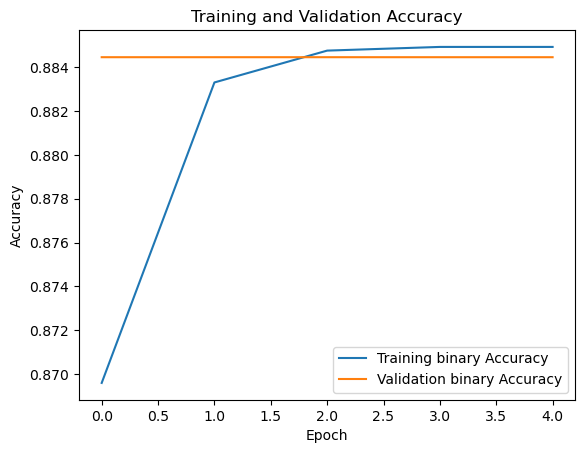

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='Training binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [63]:
resnet152_model.evaluate(test_generator)

125/125 [==============================] - 118s 941ms/step - loss: 0.3119 - binary_accuracy: 0.8847 - mae: 0.1801


[0.31191959977149963, 0.8846609592437744, 0.1800662875175476]

# LETS TRAIN VGG19

In [64]:
from tensorflow.keras.layers import Resizing, Rescaling, Permute
import tensorflow as tf
resize_rescale_hf_without_transpose = tf.keras.Sequential ( [
    Resizing (224, 224),
    Rescaling (1./255),
])

In [65]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the pretrained VGG19 model
pretrained_model = VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Freeze layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add layers for classification on top of VGG19
inputs = Input(shape = (256,256,3))
x= resize_rescale_hf_without_transpose(inputs)
x = pretrained_model(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

# Create the final model
vgg19_model = Model(inputs=inputs, outputs=predictions)

# Print model summary
vgg19_model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dense_5 (Dense)             (None, 14)                7182      
                                                            

In [15]:
#vgg19_model.load_weights("/kaggle/input/saved-models-all/all_models/best_weights_vgg19.h5")

In [66]:
vgg19_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="/kaggle/working/best_weights_vgg19.h5",  # Replace with the desired save path
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [68]:
early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=4,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

In [69]:
history = vgg19_model.fit(
train_generator,
#batch_size = 32,
steps_per_epoch=STEP_SIZE_TRAIN,
validation_steps=STEP_SIZE_VALID,
validation_data = val_generator,
epochs = 10,
verbose = 1,
callbacks = [checkpoint_callback,early_stopping_callback]
#class_weight = class_weights,
#callbacks = [checkpoint_callback]
)

Epoch 1/10
875/875 [==============================] - ETA: 0s - loss: 0.3364 - binary_accuracy: 0.8784 - mae: 0.1827
Epoch 1: val_binary_accuracy improved from -inf to 0.88446, saving model to /kaggle/working/best_weights_vgg19.h5
875/875 [==============================] - 1442s 2s/step - loss: 0.3364 - binary_accuracy: 0.8784 - mae: 0.1827 - val_loss: 0.3226 - val_binary_accuracy: 0.8845 - val_mae: 0.1786
Epoch 2/10
875/875 [==============================] - ETA: 0s - loss: 0.3136 - binary_accuracy: 0.8846 - mae: 0.1828
Epoch 2: val_binary_accuracy did not improve from 0.88446
875/875 [==============================] - 1444s 2s/step - loss: 0.3136 - binary_accuracy: 0.8846 - mae: 0.1828 - val_loss: 0.3117 - val_binary_accuracy: 0.8845 - val_mae: 0.1798
Epoch 3/10
875/875 [==============================] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8849 - mae: 0.1828
Epoch 3: val_binary_accuracy did not improve from 0.88446
875/875 [==============================] - 1364s 2s/step - lo

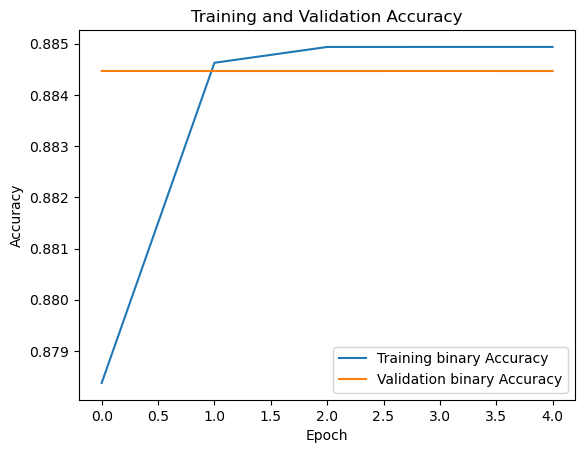

In [70]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='Training binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [74]:
vgg19_model.save("/kaggle/working/vgg19_model.h5")

In [73]:
vgg19_model.evaluate(test_generator)

125/125 [==============================] - 110s 880ms/step - loss: 0.3232 - binary_accuracy: 0.8847 - mae: 0.1786


[0.3231593668460846, 0.8846609592437744, 0.1785861998796463]

# LETS TRAIN XCEPTION MODEL

In [75]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

# Load the pretrained Xception model
pretrained_model = Xception(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Freeze layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add layers for classification on top of Xception
inputs = Input(shape = (256,256,3))
x= resize_rescale_hf_without_transpose(inputs)
x = pretrained_model(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

# Create the final model
large_xception_model = Model(inputs=inputs, outputs=predictions)

# Print model summary
large_xception_model.summary()


83683744/83683744 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, None)    0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 dense_7 (Dense)             (None, 14)                7182      
                                                            

In [76]:
#large_xception_model.load_weights("/kaggle/input/saved-models-all/all_models/best_weights_xception.h5")

In [77]:
large_xception_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="/kaggle/working/best_weights_xception.h5",  # Replace with the desired save path
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [79]:
early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=2,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

In [80]:
history = large_xception_model.fit(
train_generator,
#batch_size = 32,
steps_per_epoch=STEP_SIZE_TRAIN,
validation_steps=STEP_SIZE_VALID,
validation_data = val_generator,
epochs = 10,
verbose = 1,
callbacks = [checkpoint_callback,early_stopping_callback]
#class_weight = class_weights,
#callbacks = [checkpoint_callback]
)

Epoch 1/10
875/875 [==============================] - ETA: 0s - loss: 0.3167 - binary_accuracy: 0.8820 - mae: 0.1795
Epoch 1: val_binary_accuracy improved from -inf to 0.84821, saving model to /kaggle/working/best_weights_xception.h5
875/875 [==============================] - 1376s 2s/step - loss: 0.3167 - binary_accuracy: 0.8820 - mae: 0.1795 - val_loss: 0.4692 - val_binary_accuracy: 0.8482 - val_mae: 0.1920
Epoch 2/10
875/875 [==============================] - ETA: 0s - loss: 0.3036 - binary_accuracy: 0.8852 - mae: 0.1785
Epoch 2: val_binary_accuracy did not improve from 0.84821
875/875 [==============================] - 1371s 2s/step - loss: 0.3036 - binary_accuracy: 0.8852 - mae: 0.1785 - val_loss: 0.4498 - val_binary_accuracy: 0.8362 - val_mae: 0.2490
Epoch 3/10
875/875 [==============================] - ETA: 0s - loss: 0.3022 - binary_accuracy: 0.8853 - mae: 0.1784
Epoch 3: val_binary_accuracy improved from 0.84821 to 0.87574, saving model to /kaggle/working/best_weights_xception

In [81]:
large_xception_model.save("/kaggle/working/xception_model.h5")

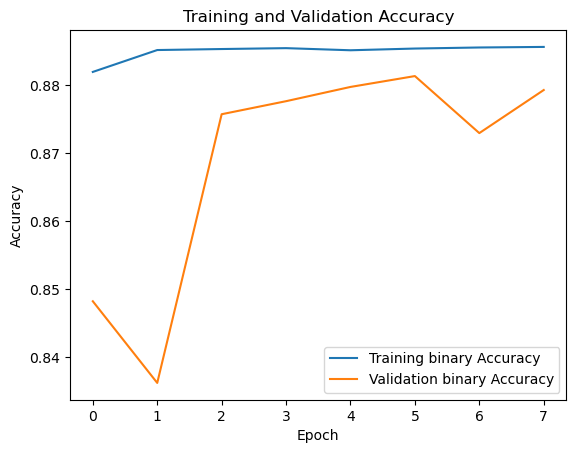

In [82]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='Training binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
large_xception_model.evaluate(test_generator)

In [ ]:
input()

# LETS ENSEMBLE USING ALL 4 MODELS

In [130]:
from transformers import AutoImageProcessor, TFViTModel
import tensorflow as tf
from tensorflow.keras.utils import custom_object_scope

custom_objects = {'TFViTMainLayer': TFViTModel}
with custom_object_scope(custom_objects):
    model1 = tf.keras.models.load_model('C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/vit_model.h5')

model2 = tf.keras.models.load_model('C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/resnet_model.h5')
model3 = tf.keras.models.load_model('C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/vgg19_model.h5')
model4 = tf.keras.models.load_model('C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/xception_model.h5')



C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [131]:
pred1 = model1.predict(val_generator)
pred2 = model2.predict(val_generator)
pred3 = model2.predict(val_generator)
pred4 = model2.predict(val_generator)
#... and so on for each model.
stacked_predictions = np.hstack((pred1, pred2, pred3, pred4))


250/250 [==============================] - 1057s 4s/step


In [132]:
import pickle

with open('D:/pickle objects/stacked_pred2.pkl', 'wb') as f:
    pickle.dump(stacked_predictions, f)

In [35]:
import pickle

# Open the pickle file for reading
with open('D:/pickle objects/stacked_pred2.pkl', 'rb') as file:
    stacked_predictions = pickle.load(file)

In [133]:
len(stacked_predictions[0])

56

In [37]:
val_labels = []
for i in range(len(val_generator)):
    _, labels_batch = val_generator[i]
    val_labels.extend(labels_batch)

val_labels = np.array(val_labels)


In [38]:
print(val_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


In [134]:
from  tensorflow.keras.layers import BatchNormalization, Dense, Dropout
import tensorflow as tf


meta_model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(stacked_predictions.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    #Dense(64, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.5),

    Dense(14, activation='sigmoid')
])


In [135]:
meta_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               29184     
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_50 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_51 (Dropout)        (None, 256)              

In [136]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/best_weights_meta_model.h5",  # Replace with the desired save path
    monitor='binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [137]:
from sklearn.metrics import hamming_loss
meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy']) # Adjust loss and metrics accordingly
meta_model.fit(stacked_predictions, val_labels, epochs=250, batch_size=32,callbacks = [checkpoint_callback])


Epoch 1/250
242/250 [============================>.] - ETA: 0s - loss: 0.6671 - binary_accuracy: 0.6704
Epoch 1: binary_accuracy improved from -inf to 0.67579, saving model to C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models\best_weights_meta_model.h5
250/250 [==============================] - 3s 5ms/step - loss: 0.6594 - binary_accuracy: 0.6758
Epoch 2/250
250/250 [==============================] - ETA: 0s - loss: 0.3554 - binary_accuracy: 0.8713
Epoch 2: binary_accuracy improved from 0.67579 to 0.87134, saving model to C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models\best_weights_meta_model.h5
250/250 [==============================] - 1s 6ms/step - loss: 0.3554 - binary_accuracy: 0.8713
Epoch 3/250
241/250 [===========================>..] - ETA: 0s - loss: 0.3313 - binary_accuracy: 0.8799
Epoch 3: binary_accuracy improved from 0.87134 to 0.87993, saving model to C:/U

250/250 [==============================] - 1s 5ms/step - loss: 0.3042 - binary_accuracy: 0.8852
Epoch 58/250
246/250 [============================>.] - ETA: 0s - loss: 0.3041 - binary_accuracy: 0.8851
Epoch 58: binary_accuracy did not improve from 0.88534
250/250 [==============================] - 1s 5ms/step - loss: 0.3040 - binary_accuracy: 0.8852
Epoch 59/250
246/250 [============================>.] - ETA: 0s - loss: 0.3041 - binary_accuracy: 0.8848
Epoch 59: binary_accuracy did not improve from 0.88534
250/250 [==============================] - 1s 5ms/step - loss: 0.3038 - binary_accuracy: 0.8849
Epoch 60/250
249/250 [============================>.] - ETA: 0s - loss: 0.3032 - binary_accuracy: 0.8853
Epoch 60: binary_accuracy did not improve from 0.88534
250/250 [==============================] - 1s 5ms/step - loss: 0.3033 - binary_accuracy: 0.8853
Epoch 61/250
249/250 [============================>.] - ETA: 0s - loss: 0.3039 - binary_accuracy: 0.8851
Epoch 61: binary_accuracy did n

243/250 [============================>.] - ETA: 0s - loss: 0.3032 - binary_accuracy: 0.8848
Epoch 89: binary_accuracy did not improve from 0.88542
250/250 [==============================] - 1s 5ms/step - loss: 0.3032 - binary_accuracy: 0.8850
Epoch 90/250
241/250 [===========================>..] - ETA: 0s - loss: 0.3028 - binary_accuracy: 0.8851
Epoch 90: binary_accuracy did not improve from 0.88542
250/250 [==============================] - 1s 5ms/step - loss: 0.3029 - binary_accuracy: 0.8851
Epoch 91/250
241/250 [===========================>..] - ETA: 0s - loss: 0.3031 - binary_accuracy: 0.8851
Epoch 91: binary_accuracy did not improve from 0.88542
250/250 [==============================] - 1s 5ms/step - loss: 0.3029 - binary_accuracy: 0.8852
Epoch 92/250
250/250 [==============================] - ETA: 0s - loss: 0.3029 - binary_accuracy: 0.8850
Epoch 92: binary_accuracy did not improve from 0.88542
250/250 [==============================] - 1s 5ms/step - loss: 0.3029 - binary_accura

250/250 [==============================] - ETA: 0s - loss: 0.3019 - binary_accuracy: 0.8854
Epoch 151: binary_accuracy did not improve from 0.88559
250/250 [==============================] - 1s 5ms/step - loss: 0.3019 - binary_accuracy: 0.8854
Epoch 152/250
242/250 [============================>.] - ETA: 0s - loss: 0.3022 - binary_accuracy: 0.8851
Epoch 152: binary_accuracy did not improve from 0.88559
250/250 [==============================] - 1s 5ms/step - loss: 0.3017 - binary_accuracy: 0.8853
Epoch 153/250
242/250 [============================>.] - ETA: 0s - loss: 0.3017 - binary_accuracy: 0.8852
Epoch 153: binary_accuracy did not improve from 0.88559
250/250 [==============================] - 1s 5ms/step - loss: 0.3017 - binary_accuracy: 0.8851
Epoch 154/250
242/250 [============================>.] - ETA: 0s - loss: 0.3015 - binary_accuracy: 0.8852
Epoch 154: binary_accuracy did not improve from 0.88559
250/250 [==============================] - 1s 5ms/step - loss: 0.3016 - binary

Epoch 214/250
243/250 [============================>.] - ETA: 0s - loss: 0.3013 - binary_accuracy: 0.8854
Epoch 214: binary_accuracy did not improve from 0.88560
250/250 [==============================] - 1s 5ms/step - loss: 0.3013 - binary_accuracy: 0.8855
Epoch 215/250
243/250 [============================>.] - ETA: 0s - loss: 0.3016 - binary_accuracy: 0.8852
Epoch 215: binary_accuracy did not improve from 0.88560
250/250 [==============================] - 1s 5ms/step - loss: 0.3013 - binary_accuracy: 0.8853
Epoch 216/250
243/250 [============================>.] - ETA: 0s - loss: 0.3018 - binary_accuracy: 0.8852
Epoch 216: binary_accuracy did not improve from 0.88560
250/250 [==============================] - 1s 5ms/step - loss: 0.3016 - binary_accuracy: 0.8852
Epoch 217/250
243/250 [============================>.] - ETA: 0s - loss: 0.3009 - binary_accuracy: 0.8856
Epoch 217: binary_accuracy improved from 0.88560 to 0.88567, saving model to C:/Users/hemal nakrani/DeepLearningProjects

250/250 [==============================] - 1s 5ms/step - loss: 0.3011 - binary_accuracy: 0.8853
Epoch 245/250
245/250 [============================>.] - ETA: 0s - loss: 0.3013 - binary_accuracy: 0.8852
Epoch 245: binary_accuracy did not improve from 0.88575
250/250 [==============================] - 1s 5ms/step - loss: 0.3013 - binary_accuracy: 0.8852
Epoch 246/250
241/250 [===========================>..] - ETA: 0s - loss: 0.3012 - binary_accuracy: 0.8854
Epoch 246: binary_accuracy did not improve from 0.88575
250/250 [==============================] - 1s 5ms/step - loss: 0.3010 - binary_accuracy: 0.8854
Epoch 247/250
243/250 [============================>.] - ETA: 0s - loss: 0.3010 - binary_accuracy: 0.8854
Epoch 247: binary_accuracy did not improve from 0.88575
250/250 [==============================] - 1s 5ms/step - loss: 0.3011 - binary_accuracy: 0.8854
Epoch 248/250
244/250 [============================>.] - ETA: 0s - loss: 0.3019 - binary_accuracy: 0.8849
Epoch 248: binary_accura

In [154]:
meta_model.save("C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/meta_model.h5")

In [107]:
meta_model = tf.keras.models.load_model('C:/Users/hemal nakrani/DeepLearningProjects/AI_Projects/chest_x_ray_classifier/backend_fastapi/saved_models/meta_model.h5')

In [109]:
test_labels = []
for i in range(len(test_generator)):
    _, labels_batch = test_generator[i]
    test_labels.extend(labels_batch)

test_labels = np.array(test_labels)


In [110]:
print(test_labels)


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]]


In [145]:
pred1_test = model1.predict(test_generator)
pred2_test = model2.predict(test_generator)
pred3_test = model2.predict(test_generator)
pred4_test = model2.predict(test_generator)
#... and so on for each model.
stacked_predictions_test = np.hstack((pred1_test, pred2_test, pred3_test, pred4_test))


125/125 [==============================] - 534s 4s/step


In [146]:
import pickle

with open('D:/pickle objects/stacked_pred_test2.pkl', 'wb') as f:
    pickle.dump(stacked_predictions_test, f)

In [46]:
import pickle

# Open the pickle file for reading
with open('D:/pickle objects/stacked_pred_test1.pkl', 'rb') as file:
    stacked_predictions_test = pickle.load(file)

In [147]:
test_pred = meta_model.predict(stacked_predictions_test)

125/125 [==============================] - 0s 3ms/step


In [148]:
#calculate hamming loss

In [149]:
print(test_pred[0])

[0.18359454 0.05097451 0.17277244 0.06607866 0.38704962 0.04331716
 0.01762195 0.00086353 0.44646183 0.12168023 0.10506276 0.08467871
 0.03691791 0.11922256]


In [150]:
def sparse_binary_convertor(pred,threshold=0.28):
    return (pred>=threshold).astype(int)
test_pred_sparse = sparse_binary_convertor(test_pred)

In [151]:
print(test_pred_sparse[0])

[0 0 0 0 1 0 0 0 1 0 0 0 0 0]


In [152]:
from sklearn.metrics import hamming_loss

# Sample true and predicted multi-label data

loss = hamming_loss(test_labels,test_pred_sparse)

print("Hamming Loss:", loss)


Hamming Loss: 0.16594642857142858


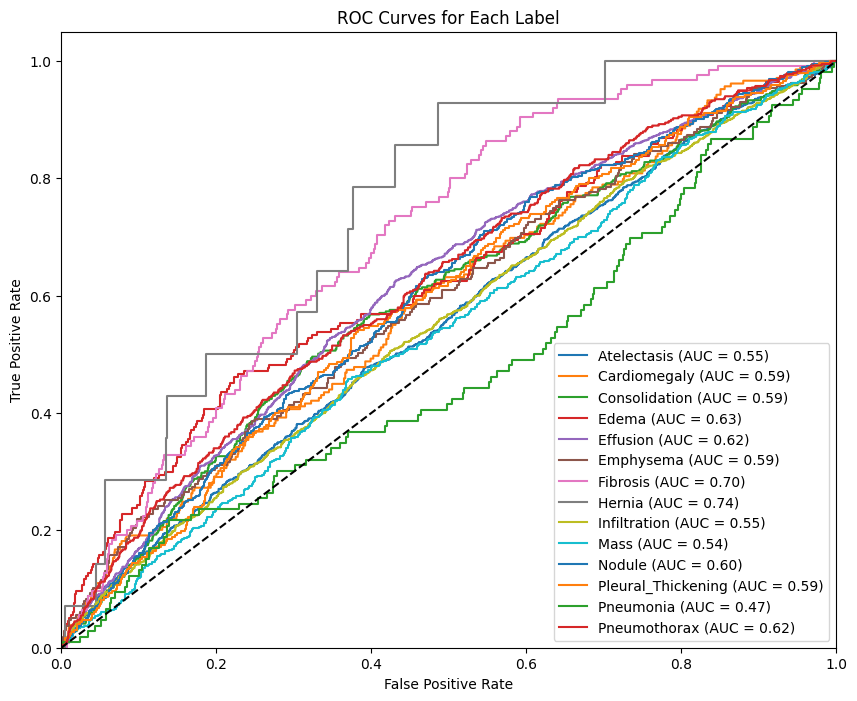

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def generate_roc_curve(test_labels,test_pred):
    # Sample true and predicted data
    y_true = test_labels
    y_score = test_pred

    n_labels = y_true.shape[1]
    label_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", 
                   "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", 
                   "Pleural_Thickening", "Pneumonia", "Pneumothorax"]

    plt.figure(figsize=(10, 8))

    for i in range(n_labels):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Label')
    plt.legend(loc="lower right")
    plt.show()

generate_roc_curve(test_labels,test_pred) 


In [64]:
from sklearn.metrics import hamming_loss, classification_report

# Sample true and predicted multi-label data
# Let's assume y_true is your ground truth and y_pred is your model's predictions
def generate_classification_report(test_labels,test_pred_sparse):
    y_true = test_labels   # ground truth for each of your samples
    y_pred = test_pred_sparse
    # Compute Hamming Loss
    loss = hamming_loss(y_true, y_pred)
    print("Hamming Loss:", loss)

    # Compute precision, recall, f1-score for each label
    report = classification_report(y_true, y_pred, target_names=["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", 
                   "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", 
                   "Pleural_Thickening", "Pneumonia", "Pneumothorax"]
    )
    print(report)

generate_classification_report(test_labels,test_pred_sparse)

Hamming Loss: 0.15817857142857142
                    precision    recall  f1-score   support

       Atelectasis       0.23      1.00      0.38       931
      Cardiomegaly       0.00      0.00      0.00       209
     Consolidation       0.00      0.00      0.00       389
             Edema       0.00      0.00      0.00       197
          Effusion       0.00      0.00      0.00      1057
         Emphysema       0.00      0.00      0.00       215
          Fibrosis       0.00      0.00      0.00       125
            Hernia       0.00      0.00      0.00        14
      Infiltration       0.38      0.33      0.35      1525
              Mass       0.00      0.00      0.00       481
            Nodule       0.00      0.00      0.00       479
Pleural_Thickening       0.00      0.00      0.00       292
         Pneumonia       0.00      0.00      0.00       106
      Pneumothorax       0.00      0.00      0.00       400

         micro avg       0.27      0.22      0.24      6420
    

C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _w

# evaluation of vit

In [326]:
vit_pred_sparse = sparse_binary_convertor(pred1_test)

In [327]:
generate_classification_report(test_labels,vit_pred_sparse)

Hamming Loss: 0.24335714285714286
                    precision    recall  f1-score   support

       Atelectasis       0.23      0.07      0.11       924
      Cardiomegaly       0.00      0.00      0.00       221
     Consolidation       0.00      0.00      0.00       376
             Edema       0.00      0.00      0.00       195
          Effusion       0.30      0.57      0.39      1083
         Emphysema       0.00      0.00      0.00       200
          Fibrosis       0.00      0.00      0.00       133
            Hernia       0.00      0.00      0.00        14
      Infiltration       0.38      1.00      0.55      1514
              Mass       0.13      0.76      0.21       491
            Nodule       0.13      0.99      0.23       514
Pleural_Thickening       0.00      0.00      0.00       291
         Pneumonia       0.00      0.00      0.00       118
      Pneumothorax       0.00      0.00      0.00       433

         micro avg       0.23      0.47      0.31      6507
    

C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


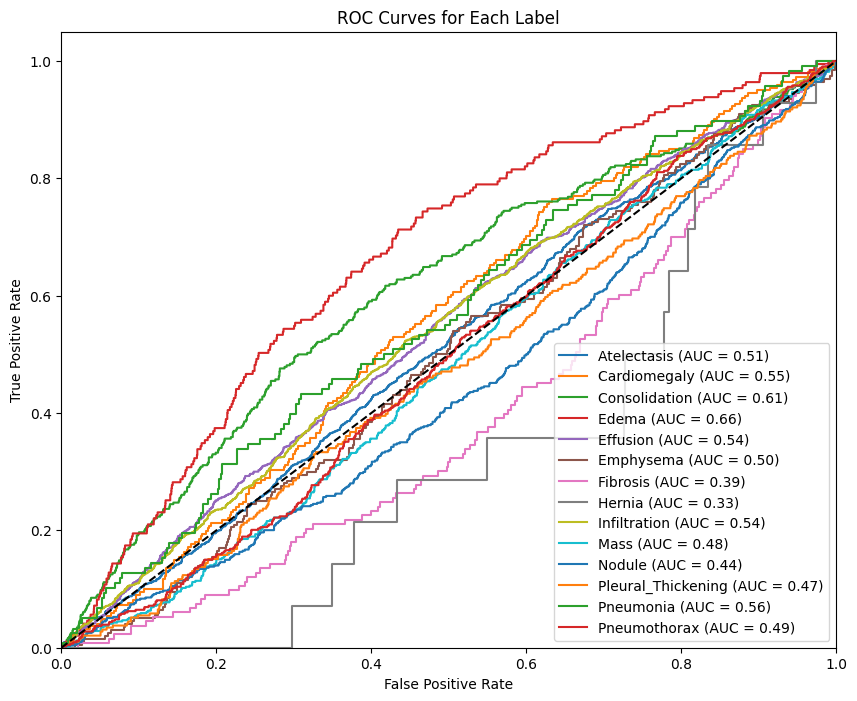

In [280]:
generate_roc_curve(test_labels,pred1_test)

# evaluation of resnet 50

In [257]:
resnet_pred_sparse = sparse_binary_convertor(pred2_test)

In [258]:
generate_classification_report(test_labels,resnet_pred_sparse)

Hamming Loss: 0.18296428571428572
                    precision    recall  f1-score   support

       Atelectasis       0.25      0.51      0.34       924
      Cardiomegaly       0.00      0.00      0.00       221
     Consolidation       0.00      0.00      0.00       376
             Edema       0.00      0.00      0.00       195
          Effusion       0.27      1.00      0.43      1083
         Emphysema       0.00      0.00      0.00       200
          Fibrosis       0.00      0.00      0.00       133
            Hernia       0.00      0.00      0.00        14
      Infiltration       0.38      1.00      0.55      1514
              Mass       0.00      0.00      0.00       491
            Nodule       0.00      0.00      0.00       514
Pleural_Thickening       0.00      0.00      0.00       291
         Pneumonia       0.00      0.00      0.00       118
      Pneumothorax       0.00      0.00      0.00       433

         micro avg       0.31      0.47      0.37      6507
    

C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


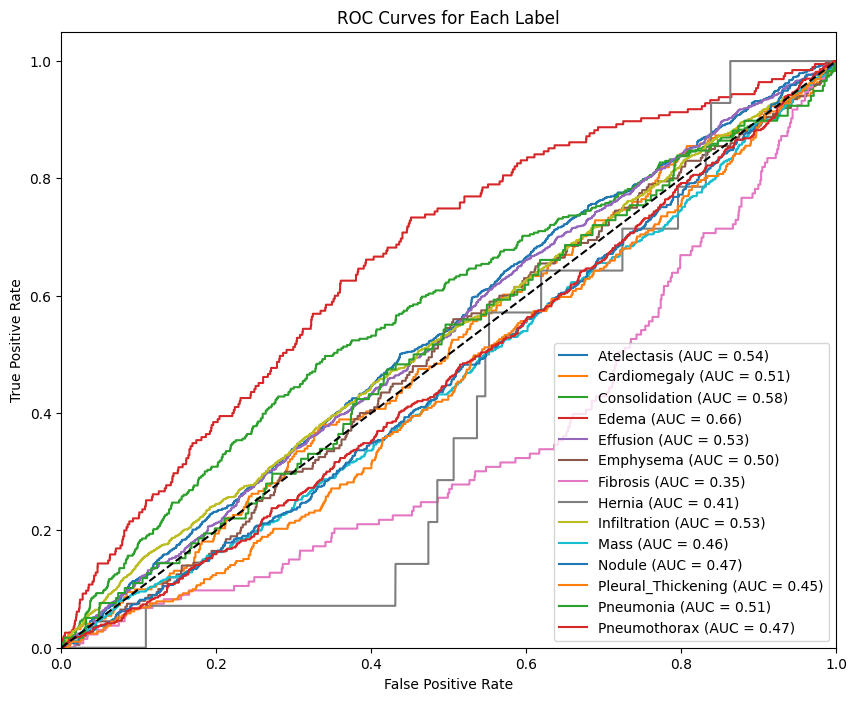

In [259]:
generate_roc_curve(test_labels,pred2_test)

# evaluation of vgg model

In [260]:
vgg_pred_sparse = sparse_binary_convertor(pred3_test)

In [261]:
generate_classification_report(test_labels,vgg_pred_sparse)

Hamming Loss: 0.18296428571428572
                    precision    recall  f1-score   support

       Atelectasis       0.25      0.51      0.34       924
      Cardiomegaly       0.00      0.00      0.00       221
     Consolidation       0.00      0.00      0.00       376
             Edema       0.00      0.00      0.00       195
          Effusion       0.27      1.00      0.43      1083
         Emphysema       0.00      0.00      0.00       200
          Fibrosis       0.00      0.00      0.00       133
            Hernia       0.00      0.00      0.00        14
      Infiltration       0.38      1.00      0.55      1514
              Mass       0.00      0.00      0.00       491
            Nodule       0.00      0.00      0.00       514
Pleural_Thickening       0.00      0.00      0.00       291
         Pneumonia       0.00      0.00      0.00       118
      Pneumothorax       0.00      0.00      0.00       433

         micro avg       0.31      0.47      0.37      6507
    

C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


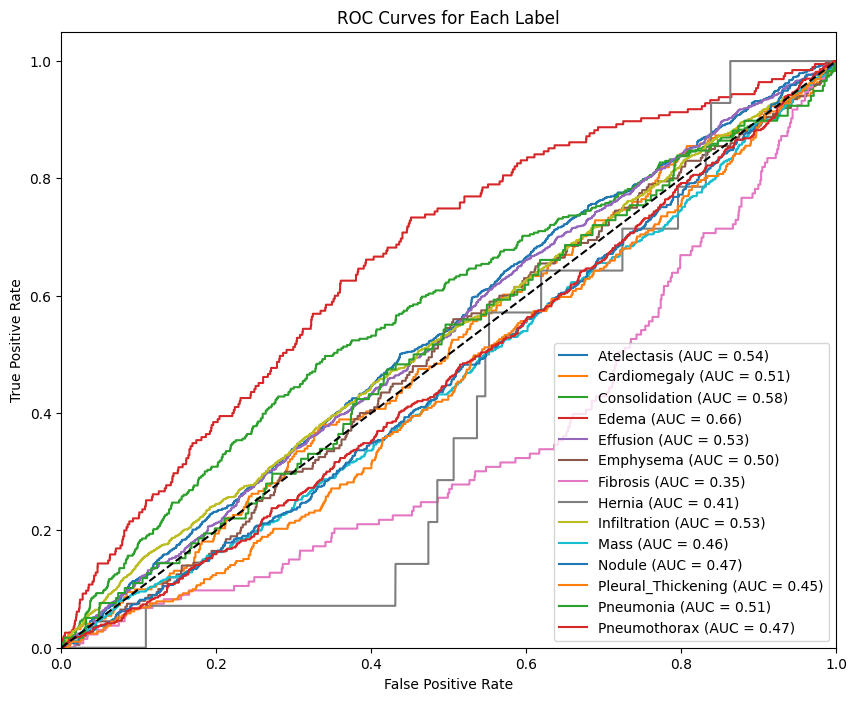

In [262]:
generate_roc_curve(test_labels,pred3_test)

# evaluation of xception model

In [263]:
xception_pred_sparse = sparse_binary_convertor(pred4_test)

In [264]:
generate_classification_report(test_labels,xception_pred_sparse)

Hamming Loss: 0.18296428571428572
                    precision    recall  f1-score   support

       Atelectasis       0.25      0.51      0.34       924
      Cardiomegaly       0.00      0.00      0.00       221
     Consolidation       0.00      0.00      0.00       376
             Edema       0.00      0.00      0.00       195
          Effusion       0.27      1.00      0.43      1083
         Emphysema       0.00      0.00      0.00       200
          Fibrosis       0.00      0.00      0.00       133
            Hernia       0.00      0.00      0.00        14
      Infiltration       0.38      1.00      0.55      1514
              Mass       0.00      0.00      0.00       491
            Nodule       0.00      0.00      0.00       514
Pleural_Thickening       0.00      0.00      0.00       291
         Pneumonia       0.00      0.00      0.00       118
      Pneumothorax       0.00      0.00      0.00       433

         micro avg       0.31      0.47      0.37      6507
    

C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hemal nakrani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


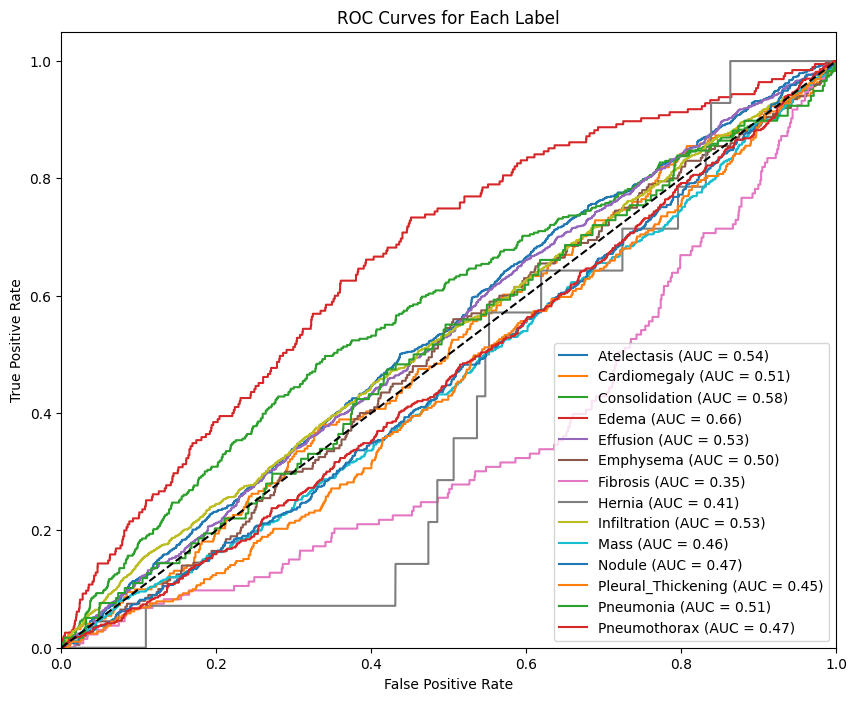

In [265]:
generate_roc_curve(test_labels,pred4_test)